In [1]:
import os
from os.path import exists

import anchor
import anchor.anchor_tabular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.inspection import DecisionBoundaryDisplay


import operator as op
from AnchorGeneration import *


In [2]:
data_path = "/Users/saranarteni/OneDrive - CNR/REXASI-PRO/T3.1/navground_code/simulation2/"
res_path = data_path+"resultsPSR_Safe/"
results_anchorfile = "anchors-csr.csv"
feature_labels = ["SafetyMargin","Eta","Tau"]
true_output = "y_true"
cp_output = "y_conformal"
#model_output = "y_pred"

rules = pd.read_csv(res_path+results_anchorfile)

model = joblib.load(data_path+"CP_SVM_safe.sav")

test = pd.read_csv(data_path+"test_cp.csv")
y_test = np.array(test[true_output])
#y_model_test = np.array(test[model_output])
y_cp_test = np.array(test[cp_output])
X_test_df = test.drop([true_output,cp_output],axis = 1)
X_test = np.array(X_test_df)



In [3]:
test.describe()

,SafetyMargin,Eta,Tau,y_true,y_conformal
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.050085,0.504349,0.494272,0.102000,0.046000
std,0.029221,0.295552,0.291230,0.995282,0.999441
min,0.000020,0.001283,0.001622,-1.000000,-1.000000
25%,0.024422,0.242766,0.239571,-1.000000,-1.000000
50%,0.050102,0.523454,0.478116,1.000000,1.000000
75%,0.076151,0.766107,0.759959,1.000000,1.000000
max,0.099955,0.999287,0.999445,1.000000,1.000000


In [4]:
# visualize the anchors for all test set
rules

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
0,0,Tau <= 0.25,0.2494,0.877069,1.0,1.0,1.0
1,1,Tau <= 0.25,0.2551,0.877358,1.0,1.0,1.0
2,2,SafetyMargin > 0.07,0.2539,0.868132,1.0,1.0,1.0
3,3,Tau <= 0.25,0.2437,0.907489,1.0,1.0,1.0
4,4,Tau <= 0.25,0.2556,0.883142,1.0,1.0,1.0
...,...,...,...,...,...,...,...
985,995,SafetyMargin <= 0.02,0.2570,0.855181,-1.0,-1.0,-1.0
986,996,Tau > 0.75,0.2425,0.826347,-1.0,-1.0,-1.0
987,997,Tau <= 0.51,0.5010,0.754986,1.0,1.0,1.0
988,998,SafetyMargin <= 0.02,0.2496,0.808989,-1.0,-1.0,1.0


In [5]:
rules[rules["AnchorOutput"]==1]["AnchorConditions"].value_counts()

AnchorConditions
Tau <= 0.25            227
SafetyMargin > 0.07    150
Tau <= 0.51             83
SafetyMargin > 0.05     45
Eta > 0.76               5
Tau <= 0.75              1
SafetyMargin > 0.02      1
Eta > 0.50               1
Name: count, dtype: int64

In [6]:
model.get_params()

{'alpha': array([0.49992162, 0.50003417, 0.49988513, ..., 0.50007678, 0.49997215,
        0.49994338]),
 'b': array([-0.05929787]),
 'b_eps': 0.14489055974142745,
 'eta': 0.3,
 'kernel': 'polynomial',
 'param': 3}

# Candidate selection

Text(0, 0.5, 'Count')

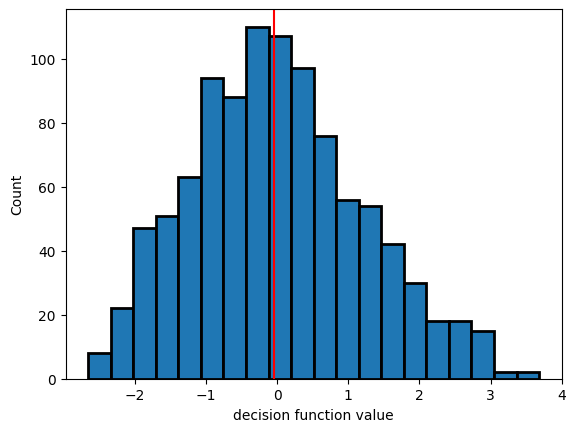

In [7]:
# distances of test points from decision boundary
d_test = model.decision_function(X_test)

plt.hist(d_test,bins = 20, edgecolor = "black",linewidth=2)
plt.gca().axvline(x=-0.05, color = "red")
plt.xlabel("decision function value")
plt.ylabel("Count")

In [8]:
min(d_test)

-2.6582334738377753

In [9]:
max(d_test)

3.683109639225027

In [10]:
model.b_eps

0.14489055974142745

In [11]:
d_thresh = 0.05

border_points_idx = np.where((d_test < 0) & (abs(d_test) < d_thresh) & (y_cp_test == 1))[0]

print(f"# of candidate points: {len(border_points_idx)}")

# of candidate points: 21


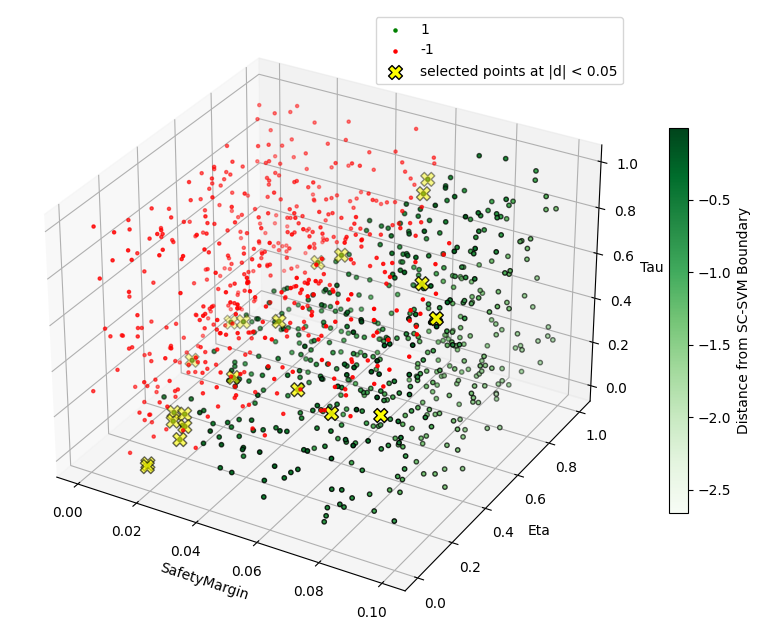

In [12]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')

sc0 = ax.scatter3D(X_test[:,0][y_cp_test == -1], X_test[:,1][y_cp_test == -1], X_test[:,2][y_cp_test == -1], s=5, c= "red")
scsafe = ax.scatter3D(X_test[:,0][y_cp_test == 1], X_test[:,1][y_cp_test == 1], X_test[:,2][y_cp_test == 1], s=5, c= "green")

sc1 = ax.scatter3D(X_test[:,0][y_cp_test == 1], X_test[:,1][y_cp_test == 1], X_test[:,2][y_cp_test == 1], s=10, c=d_test[y_cp_test == 1], cmap = "Greens", edgecolors = "k")

sc2 = ax.scatter3D(X_test[list(border_points_idx),0],X_test[list(border_points_idx),1], X_test[list(border_points_idx),2],s=100, marker = 'X', facecolors="yellow", edgecolors="k")


ax.set_xlabel("SafetyMargin")
ax.set_ylabel("Eta")
ax.set_zlabel("Tau")



ax.legend([scsafe, sc0,sc2], ["1","-1",f"selected points at |d| < {d_thresh}"], loc="upper right")
plt.colorbar(sc1, label = "Distance from SC-SVM Boundary", shrink = 0.5)

plt.show()

# Select the anchors for the candidate points

In [13]:
rule_cand_idx = np.array(rules[rules["Index"].isin(border_points_idx)==True].index)

In [14]:
# get rules generated on the selected boundary points
rules_candidates = rules.iloc[rule_cand_idx,:]

In [15]:
# focus on non collision class (label +1)
rules_noncoll = rules_candidates[rules_candidates["AnchorOutput"] == 1]
'''
# define a threshold for filtering on covering
covering_threshold = 0.1

rules_selected = rules_noncoll[rules_noncoll["Coverage"]>= covering_threshold]

rules_selected = rules_selected.sort_values(by = ["Coverage"], axis = 0, ascending = False)

rules_selected
'''

'\n# define a threshold for filtering on covering\ncovering_threshold = 0.1\n\nrules_selected = rules_noncoll[rules_noncoll["Coverage"]>= covering_threshold]\n\nrules_selected = rules_selected.sort_values(by = ["Coverage"], axis = 0, ascending = False)\n\nrules_selected\n'

In [16]:
rules_noncoll["AnchorConditions"].value_counts()

AnchorConditions
Tau <= 0.25            9
Tau <= 0.51            4
SafetyMargin > 0.07    4
SafetyMargin > 0.05    2
Tau <= 0.75            1
Name: count, dtype: int64

# Performance Evaluation


In [20]:
def evaluate_rules(data, tuned_rules, output):
    predictions_all = []
    for i, rule in tuned_rules.iterrows():
        pred_rule = []
        tptot = 0
        tntot = 0
        fntot = 0
        fptot = 0
        tuned_antecedent = rule['AnchorConditions'].strip()
        print(f"rule: {tuned_antecedent}")
        for _, row in data.iterrows():
            y_row = row[output]
            tp = 0
            tn = 0
            fn = 0
            fp = 0
            # check if the point row satifies rule 
            if evaluate_rule_conditions(row, tuned_antecedent):
                # rule is satisfied
                satisfied = True
                pred_rule.append(1)
            else:
                satisfied = False
                pred_rule.append(-1)
    
            
            if satisfied and y_row == 1:
                tp=1
            elif satisfied and y_row == -1:
                fp=1
            elif not satisfied and y_row == -1:
                tn=1
            
            elif not satisfied and y_row == 1:
                fn=1
            predictions_all.append(pred_rule)
            tptot+=tp
            tntot+=tn
            fptot+=fp
            fntot+=fn

        
        print(f"tp = {tptot}, tn = {tntot}, fp = {fptot}, fn = {fntot}")
        prec = tptot / (tptot+fptot)
        cov = tptot/(tptot+fntot)
        acc = (tptot+tntot)/(tptot+tntot+fptot+fntot)
        f1score = (2*tptot)/(2*tptot+fptot+fntot)
        err = fptot/(tntot+fptot)
        print(f"precision: {prec}, covering: {cov}, error: {err}, accuracy: {acc}, f1: {f1score}\n")          

    return predictions_all


def evaluate_rule_conditions(row, condition_part):

    # Checks if any of the conditions in the rule are satisfied
    if all(check_condition(row, part) for part in condition_part.split(" AND ")):
        return True  # Return True if all conditions in the rule are satisfied
    
    return False  # Return False if any of the conditions in the rule is not satisfied


def check_condition(row, condition_part):
    # Check if a single condition part is satisfied
    
    parts = [part.strip('()') for part in condition_part.split()]
    #print("parts: ", parts)
    if len(parts) == 3:
        column, op, value = parts
        return eval(f"{row[column]} {op} {value}")
    # handle the case of a 2-thresholds conditions of the kind: a < Column <= b
    elif len(parts) == 5:
        val1,op1,column,op2,val2 = parts
        # Use the original condition from the rule
        return eval(f"{val1} {op1} {row[column]} {op2} {val2}")        
    else:
        # Handle cases where the condition is not in the expected format
        pass

# SafetyMargin > 0.05 AND Tau <= 0.25 AND Eta > 0.25


In [18]:
rules_noncoll_unique = rules_noncoll.drop_duplicates(subset = "AnchorConditions")
rules_noncoll_unique

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
37,37,Tau <= 0.25,0.2518,0.912037,1.0,1.0,-1.0
74,74,Tau <= 0.75,0.7550,0.646504,1.0,1.0,-1.0
222,223,Tau <= 0.51,0.5045,0.794163,1.0,1.0,1.0
278,279,SafetyMargin > 0.07,0.2495,0.835275,1.0,1.0,-1.0
374,378,SafetyMargin > 0.05,0.5005,0.776567,1.0,1.0,-1.0


# Evaluation on true labels

In [21]:
preds_by_rule = evaluate_rules(test, rules_noncoll_unique, true_output)

rule: Tau <= 0.25
tp = 202, tn = 391, fp = 58, fn = 349
precision: 0.7769230769230769, covering: 0.3666061705989111, error: 0.1291759465478842, accuracy: 0.593, f1: 0.49815043156596794

rule: Tau <= 0.75
tp = 470, tn = 183, fp = 266, fn = 81
precision: 0.6385869565217391, covering: 0.852994555353902, error: 0.5924276169265034, accuracy: 0.653, f1: 0.7303807303807304

rule: Tau <= 0.51
tp = 374, tn = 295, fp = 154, fn = 177
precision: 0.7083333333333334, covering: 0.6787658802177858, error: 0.3429844097995546, accuracy: 0.669, f1: 0.6932344763670065

rule: SafetyMargin > 0.07
tp = 273, tn = 410, fp = 39, fn = 278
precision: 0.875, covering: 0.4954627949183303, error: 0.08685968819599109, accuracy: 0.683, f1: 0.6326767091541136

rule: SafetyMargin > 0.05
tp = 417, tn = 362, fp = 87, fn = 134
precision: 0.8273809523809523, covering: 0.7568058076225045, error: 0.19376391982182628, accuracy: 0.779, f1: 0.790521327014218



# evaluation on safety checker labels

In [22]:
preds_by_rule_cp = evaluate_rules(test, rules_noncoll_unique, cp_output)

rule: Tau <= 0.25
tp = 234, tn = 451, fp = 26, fn = 289
precision: 0.9, covering: 0.4474187380497132, error: 0.05450733752620545, accuracy: 0.685, f1: 0.5977011494252874

rule: Tau <= 0.75
tp = 473, tn = 214, fp = 263, fn = 50
precision: 0.6426630434782609, covering: 0.904397705544933, error: 0.5513626834381551, accuracy: 0.687, f1: 0.7513899920571883

rule: Tau <= 0.51
tp = 394, tn = 343, fp = 134, fn = 129
precision: 0.7462121212121212, covering: 0.7533460803059273, error: 0.2809224318658281, accuracy: 0.737, f1: 0.7497621313035204

rule: SafetyMargin > 0.07
tp = 258, tn = 423, fp = 54, fn = 265
precision: 0.8269230769230769, covering: 0.4933078393881453, error: 0.11320754716981132, accuracy: 0.681, f1: 0.6179640718562874

rule: SafetyMargin > 0.05
tp = 381, tn = 354, fp = 123, fn = 142
precision: 0.7559523809523809, covering: 0.7284894837476099, error: 0.2578616352201258, accuracy: 0.735, f1: 0.7419668938656281



In [3]:
verified1 = (X_test[:,0] > 0.07) 

verified2 = (X_test[:,2] <= 0.25) 

verified_or = verified1|verified2

prec, cov, acc, fscore = ComputeMetricsForRule(verified_or, y_cp_test)
print(f"precision: {prec}, covering: {cov}, accuracy: {acc}, f1: {fscore}")   

tp = 407, tn = 397, fp = 80, fn = 116
precision: 0.8357289527720739, covering: 0.7782026768642447, accuracy: 0.804, f1: 0.805940594059406
